## Problem Statement 

You need to build a model that is able to classify customer complaints based on the products/services. By doing so, you can segregate these tickets into their relevant categories and, therefore, help in the quick resolution of the issue.

You will be doing topic modelling on the <b>.json</b> data provided by the company. Since this data is not labelled, you need to apply NMF to analyse patterns and classify tickets into the following five clusters based on their products/services:

* Credit card / Prepaid card

* Bank account services

* Theft/Dispute reporting

* Mortgages/loans

* Others 


With the help of topic modelling, you will be able to map each ticket onto its respective department/category. You can then use this data to train any supervised model such as logistic regression, decision tree or random forest. Using this trained model, you can classify any new customer complaint support ticket into its relevant department.

## Pipelines that needs to be performed:

You need to perform the following eight major tasks to complete the assignment:

1.  Data loading

2. Text preprocessing

3. Exploratory data analysis (EDA)

4. Feature extraction

5. Topic modelling 

6. Model building using supervised learning

7. Model training and evaluation

8. Model inference

## Importing the necessary libraries

In [1]:
import json 
import numpy as np
import pandas as pd
from tqdm import tqdm
tqdm.pandas()
import re, nltk, spacy, string

nlp = spacy.load("C:/Users/rrraj/AppData/Roaming/Python/Python38/site-packages/en_core_web_sm/en_core_web_sm-3.0.0")
import seaborn as sns
from textblob import TextBlob
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
%matplotlib inline

from plotly.offline import plot
import plotly.graph_objects as go
import plotly.express as px

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from pprint import pprint

from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import confusion_matrix, f1_score, classification_report

## Loading the data

The data is in JSON format and we need to convert it to a dataframe.

In [2]:
# Opening JSON file 
f = "complaints-2021-05-14_08_16.json"# Write the path to your data file and load it 
  
# returns JSON object as  
# a dictionary 
with open(f,'r') as file:
    data = json.load(file)
df=pd.json_normalize(data)

## Data preparation

In [3]:
# Inspect the dataframe to understand the given data.
df.head(4)


,_index,_type,_id,_score,_source.tags,_source.zip_code,_source.complaint_id,_source.issue,_source.date_received,_source.state,...,_source.company_response,_source.company,_source.submitted_via,_source.date_sent_to_company,_source.company_public_response,_source.sub_product,_source.timely,_source.complaint_what_happened,_source.sub_issue,_source.consumer_consent_provided
0,complaint-public-v2,complaint,3211475,0.0,None,90301,3211475,Attempts to collect debt not owed,2019-04-13T12:00:00-05:00,CA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-13T12:00:00-05:00,None,Credit card debt,Yes,,Debt is not yours,Consent not provided
1,complaint-public-v2,complaint,3229299,0.0,Servicemember,319XX,3229299,Written notification about debt,2019-05-01T12:00:00-05:00,GA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-05-01T12:00:00-05:00,None,Credit card debt,Yes,Good morning my name is XXXX XXXX and I apprec...,Didn't receive enough information to verify debt,Consent provided
2,complaint-public-v2,complaint,3199379,0.0,None,77069,3199379,"Other features, terms, or problems",2019-04-02T12:00:00-05:00,TX,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-02T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,I upgraded my XXXX XXXX card in XX/XX/2018 and...,Problem with rewards from credit card,Consent provided
3,complaint-public-v2,complaint,2673060,0.0,None,48066,2673060,Trouble during payment process,2017-09-13T12:00:00-05:00,MI,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2017-09-14T12:00:00-05:00,None,Conventional home mortgage,Yes,,None,Consent not provided


In [4]:
df.shape

(78313, 22)

In [5]:
#print the column names
df.columns

Index(['_index', '_type', '_id', '_score', '_source.tags', '_source.zip_code',
       '_source.complaint_id', '_source.issue', '_source.date_received',
       '_source.state', '_source.consumer_disputed', '_source.product',
       '_source.company_response', '_source.company', '_source.submitted_via',
       '_source.date_sent_to_company', '_source.company_public_response',
       '_source.sub_product', '_source.timely',
       '_source.complaint_what_happened', '_source.sub_issue',
       '_source.consumer_consent_provided'],
      dtype='object')

In [6]:
#Assign new column names
df.rename(columns={'_index':'index', '_type':'type', '_id':'id', '_score':'score',
                    '_source.complaint_what_happened':'complaints_what_happened', '_source.product':'product',
                   '_source.zip_code':'zip_code','_source.complaint_id':'complaint_id', '_source.issue':'issue',
                  '_source.tags':'tags','_source.date_received':'date_received','_source.state':'state',
                   '_source.consumer_disputed':'consumer_disputed','_source.company_response':'company_response',
                  '_source.company':'company','_source.submitted_via':'submitted_via','_source.date_sent_to_company':'date_sent_to_company', '_source.company_public_response':'company_public_response',
                   '_source.sub_product':'sub_product', '_source.timely':'timely', '_source.sub_issue':'sub_issue',
                   '_source.consumer_consent_provided':'consumer_consent_provided'}, inplace=True)
df.columns

Index(['index', 'type', 'id', 'score', 'tags', 'zip_code', 'complaint_id',
       'issue', 'date_received', 'state', 'consumer_disputed', 'product',
       'company_response', 'company', 'submitted_via', 'date_sent_to_company',
       'company_public_response', 'sub_product', 'timely',
       'complaints_what_happened', 'sub_issue', 'consumer_consent_provided'],
      dtype='object')

In [7]:
#Assign nan in place of blanks in the complaints column
df['complaints_what_happened'].replace("", np.nan, inplace=True)

In [8]:
#Remove all rows where complaints column is nan
df.dropna(subset=['complaints_what_happened'], inplace=True)

## Prepare the text for topic modeling

Once you have removed all the blank complaints, you need to:

* Make the text lowercase
* Remove text in square brackets
* Remove punctuation
* Remove words containing numbers


Once you have done these cleaning operations you need to perform the following:
* Lemmatize the texts
* Extract the POS tags of the lemmatized text and remove all the words which have tags other than NN[tag == "NN"].


In [9]:
# Write your function here to clean the text and remove all the unnecessary elements.
def clean_noisy_text(text):
    #Make the text lowercase
    text=text.lower()
    
    #Remove text in square brackets
    text=re.sub(r'\[.*?\]','',text)
    
    #Remove punctuation
    text=re.sub(r'[%s]%re.escape(string.punctuation)','',text)
    
    #Remove words containing numbers
    text = re.sub(r'\w*\d\w*', '', text)
    
    return text

In [10]:
#Write your function to Lemmatize the texts
def lemmatize_text(text):     
        
    # Initialize empty list to store lemmas
    lemma_list = []
    
    # Extract lemmas of given text and add to the list 'sent'
    document = nlp(text)
    for word in document:
        lemma_list.append(word.lemma_)
        
    # return string converted form of the list of lemmas
    return " ".join(lemma_list)

In [11]:
#Create a dataframe('df_clean') that will have only the complaints and the lemmatized complaints 
df_clean = df[['complaints_what_happened']] 
df_clean['lemmatized_complaints'] = df_clean['complaints_what_happened'].progress_apply(lambda x: lemmatize_text(x))

100%|████████████████████████████████████████████████████████████████████████████| 21072/21072 [10:35<00:00, 33.18it/s]
C:\Users\rrraj\AppData\Local\Temp\ipykernel_32616\2963758196.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [12]:
df_clean

,complaints_what_happened,lemmatized_complaints
1,Good morning my name is XXXX XXXX and I apprec...,good morning my name be xxxx XXXX and I apprec...
2,I upgraded my XXXX XXXX card in XX/XX/2018 and...,I upgrade my xxxx xxxx card in XX / XX/2018 an...
10,Chase Card was reported on XX/XX/2019. However...,Chase Card be report on XX / XX/2019 . however...
11,"On XX/XX/2018, while trying to book a XXXX XX...","on XX / XX/2018 , while try to book a xxxx x..."
14,my grand son give me check for {$1600.00} i de...,my grand son give I check for { $ 1600.00 } I ...
...,...,...
78303,After being a Chase Card customer for well ove...,after be a Chase Card customer for well over a...
78309,"On Wednesday, XX/XX/XXXX I called Chas, my XXX...","on Wednesday , XX / XX / XXXX I call Chas , my..."
78310,I am not familiar with XXXX pay and did not un...,I be not familiar with xxxx pay and do not und...
78311,I have had flawless credit for 30 yrs. I've ha...,I have have flawless credit for 30 yrs . I 've...


In [13]:
#Write your function to extract the POS tags 

def get_pos_tag(text):
  # write your code here
    # Creating a textblob object
    text_blob = TextBlob(text)

    # extracting words with tags 'NN', joining them and return
    return ' '.join([ word for (word,tag) in text_blob.tags if tag == "NN"])



df_clean["complaint_POS_removed"] =  df_clean['lemmatized_complaints'].progress_apply(lambda x: get_pos_tag(x))#this column should contain lemmatized text with all the words removed which have tags other than NN[tag == "NN"].


100%|████████████████████████████████████████████████████████████████████████████| 21072/21072 [06:09<00:00, 57.04it/s]
C:\Users\rrraj\AppData\Local\Temp\ipykernel_32616\1988406740.py:13: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [14]:
#The clean dataframe should now contain the raw complaint, lemmatized complaint and the complaint after removing POS tags.
df_clean

,complaints_what_happened,lemmatized_complaints,complaint_POS_removed
1,Good morning my name is XXXX XXXX and I apprec...,good morning my name be xxxx XXXX and I apprec...,morning name stop service ask debt verificatio...
2,I upgraded my XXXX XXXX card in XX/XX/2018 and...,I upgrade my xxxx xxxx card in XX / XX/2018 an...,card agent upgrade date agent information orde...
10,Chase Card was reported on XX/XX/2019. However...,Chase Card be report on XX / XX/2019 . however...,application identity consent service credit id...
11,"On XX/XX/2018, while trying to book a XXXX XX...","on XX / XX/2018 , while try to book a xxxx x...",try book xxxx ticket offer ticket card informa...
14,my grand son give me check for {$1600.00} i de...,my grand son give I check for { $ 1600.00 } I ...,son chase account fund bank account pay money ...
...,...,...,...
78303,After being a Chase Card customer for well ove...,after be a Chase Card customer for well over a...,customer decade solicitation credit card airli...
78309,"On Wednesday, XX/XX/XXXX I called Chas, my XXX...","on Wednesday , XX / XX / XXXX I call Chas , my...",provider claim purchase protection benefit sch...
78310,I am not familiar with XXXX pay and did not un...,I be not familiar with xxxx pay and do not und...,pay risk provide consumer bank app year mobile...
78311,I have had flawless credit for 30 yrs. I've ha...,I have have flawless credit for 30 yrs . I 've...,credit yrs credit card xxxx problem balance tr...


## Exploratory data analysis to get familiar with the data.

Write the code in this task to perform the following:

*   Visualise the data according to the 'Complaint' character length
*   Using a word cloud find the top 40 words by frequency among all the articles after processing the text
*   Find the top unigrams,bigrams and trigrams by frequency among all the complaints after processing the text. ‘




Text(0, 0.5, 'Noumber of Complaints')

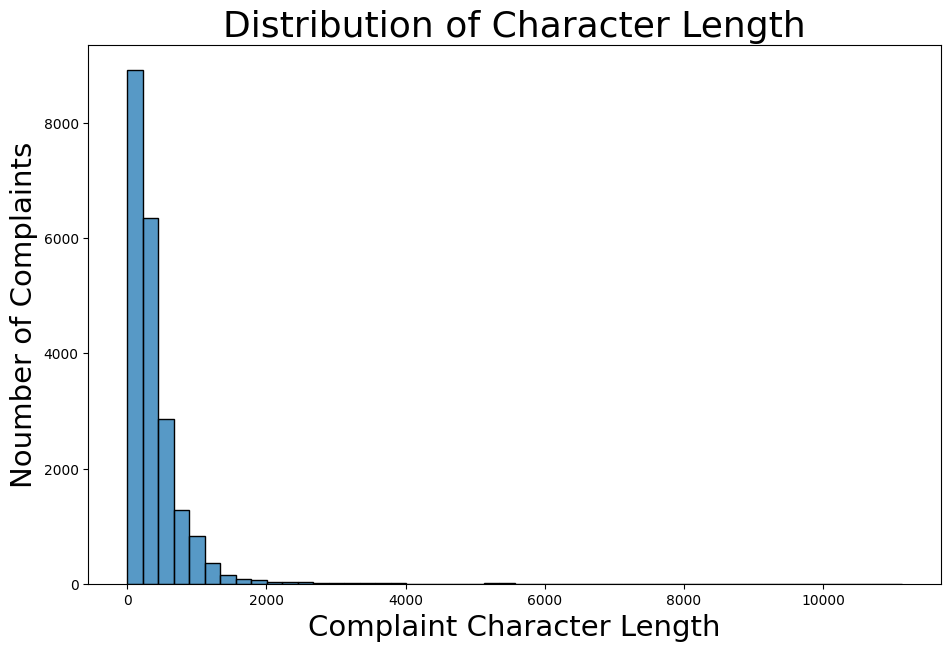

In [15]:
# Write your code here to visualise the data according to the 'Complaint' character length

# Check character length
char_length=[len(x) for x in df_clean['complaint_POS_removed']]

plt.figure(figsize=[11,7])
sns.histplot(data = char_length,bins=50)
plt.title('Distribution of Character Length', fontsize=26)
plt.xlabel('Complaint Character Length',size=21)
plt.ylabel('Noumber of Complaints',size=21)

#### Find the top 40 words by frequency among all the articles after processing the text.

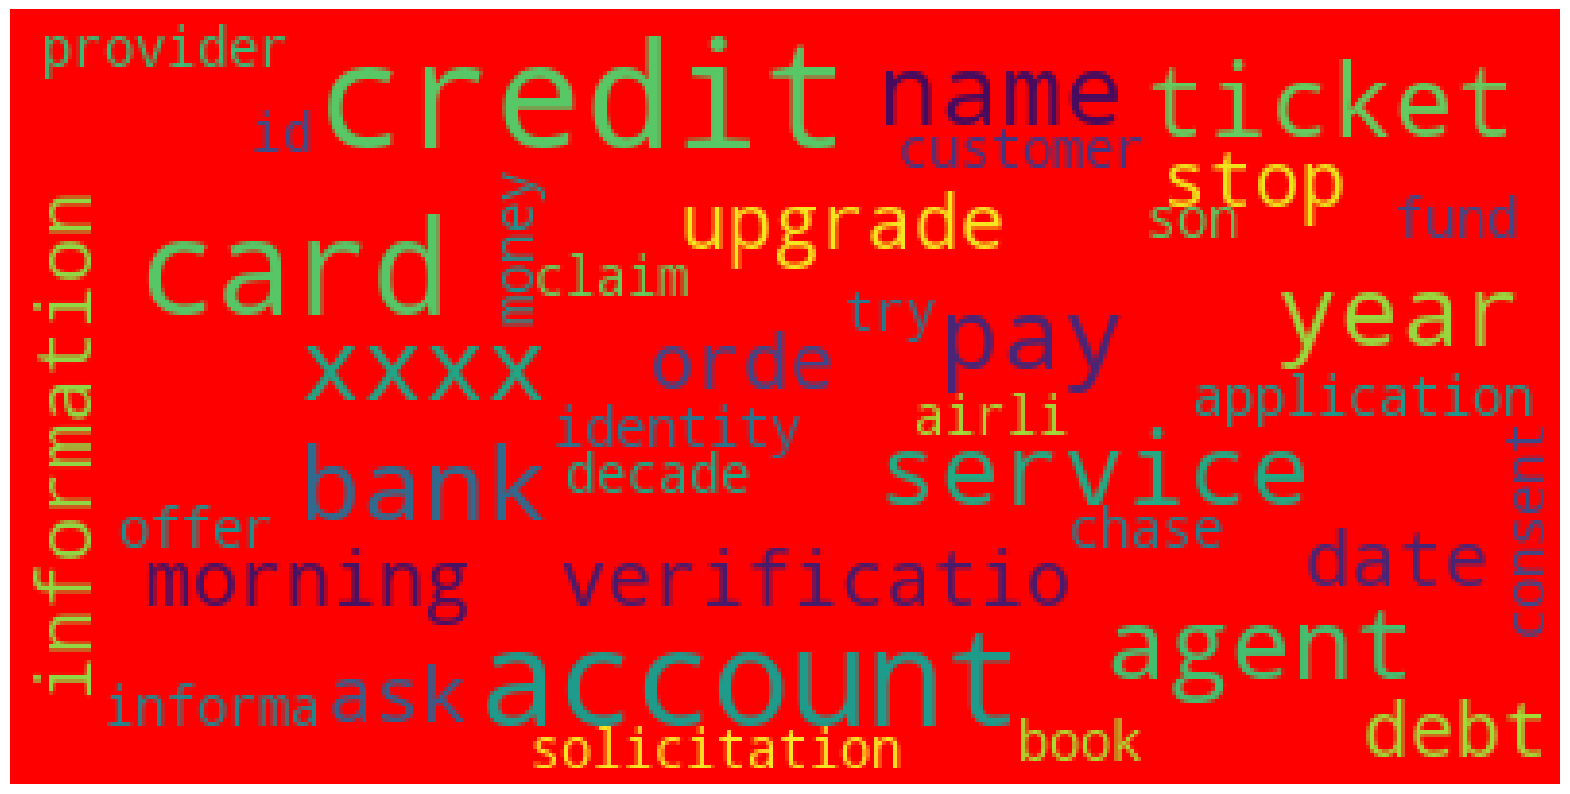

In [70]:
#Using a word cloud find the top 40 words by frequency among all the articles after processing the text

# Unioque Stopwords
stop_words = set(STOPWORDS)
word_cloud = WordCloud(
                          background_color='red',
                          stopwords=stop_words,
                          max_font_size=38,
                          max_words=38, 
                          random_state=42
                         ).generate(str(df_clean['complaint_POS_removed']))

fig = plt.figure(figsize=(20,16))
plt.imshow(word_cloud)
plt.axis('off')
plt.show()

In [17]:
#Removing -PRON- from the text corpus
df_clean['Complaint_clean'] = df_clean['complaint_POS_removed'].str.replace('-PRON-', '')

C:\Users\rrraj\AppData\Local\Temp\ipykernel_32616\3655474111.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [18]:
df_clean.shape

(21072, 4)

#### Find the top unigrams,bigrams and trigrams by frequency among all the complaints after processing the text.

In [19]:
#Write your code here to find the top 30 unigram frequency among the complaints in the cleaned datafram(df_clean). 
def unigram(text, n=30):

    vector = CountVectorizer(stop_words='english').fit(text)
    bag_of_words = vector.transform(text)
    sum_of_words = bag_of_words.sum(axis=0) 
    word_freq = [(word, sum_of_words[0, idx]) for word, idx in vector.vocabulary_.items()]
    word_freq =sorted(word_freq, key = lambda x: x[1], reverse=True)
    return word_freq[:n]

In [20]:
#Print the top 10 words in the unigram frequency
common_words = unigram(df_clean['complaint_POS_removed'].values.astype('U'))
unigram_frame = pd.DataFrame(common_words, columns = ['unigram' , 'count'])
unigram_frame.head(10)

,unigram,count
0,account,46634
1,credit,30927
2,xxxx,30775
3,card,26828
4,payment,20919
5,bank,18482
6,time,16114
7,charge,14926
8,day,13135
9,money,11957


In [21]:
#Write your code here to find the top 30 bigram frequency among the complaints in the cleaned datafram(df_clean). 
def bigram(text, n=30):

    vector = CountVectorizer(ngram_range=(2, 2), stop_words='english').fit(text)
    bag_of_words = vector.transform(text)
    sum_of_words = bag_of_words.sum(axis=0) 
    word_freq = [(word, sum_of_words[0, idx]) for word, idx in vector.vocabulary_.items()]
    word_freq =sorted(word_freq, key = lambda x: x[1], reverse=True)
    return word_freq[:n]

In [22]:
#Print the top 10 words in the bigram frequency
bigram_common_words = bigram(df_clean['complaint_POS_removed'].values.astype('U'))
bigram_frame = pd.DataFrame(bigram_common_words, columns = ['bigram' , 'count'])
bigram_frame.head(10)

,bigram,count
0,credit card,11222
1,xxxx xxxx,3909
2,credit report,3715
3,account account,2747
4,customer service,2635
5,bank account,2304
6,checking account,1864
7,card account,1602
8,account credit,1576
9,debit card,1521


In [23]:
#Write your code here to find the top 30 trigram frequency among the complaints in the cleaned datafram(df_clean). 
def trigram(text, n=30):

    vector = CountVectorizer(ngram_range=(3, 3), stop_words='english').fit(text)
    bag_of_words = vector.transform(text)
    sum_of_words = bag_of_words.sum(axis=0) 
    word_freq = [(word, sum_of_words[0, idx]) for word, idx in vector.vocabulary_.items()]
    word_freq =sorted(word_freq, key = lambda x: x[1], reverse=True)
    return word_freq[:n]

In [24]:
#Print the top 10 words in the trigram frequency
trigram_common_words = trigram(df_clean['complaint_POS_removed'].values.astype('U'))
trigram_frame = pd.DataFrame(trigram_common_words, columns = ['trigram' , 'count'])
trigram_frame.head(10)

,trigram,count
0,credit card account,1018
1,credit card company,898
2,xxxx xxxx xxxx,702
3,credit card credit,547
4,charge credit card,514
5,inquiry credit report,468
6,account credit card,448
7,card credit card,446
8,credit reporting agency,326
9,xxxx credit card,310


## The personal details of customer has been masked in the dataset with xxxx. Let's remove the masked text as this will be of no use for our analysis

In [25]:
df_clean['Complaint_clean'] = df_clean['Complaint_clean'].str.replace('xxxx','')

C:\Users\rrraj\AppData\Local\Temp\ipykernel_32616\619742717.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [26]:
df_clean.shape

(21072, 4)

In [27]:
#All masked texts has been removed
df_clean

,complaints_what_happened,lemmatized_complaints,complaint_POS_removed,Complaint_clean
1,Good morning my name is XXXX XXXX and I apprec...,good morning my name be xxxx XXXX and I apprec...,morning name stop service ask debt verificatio...,morning name stop service ask debt verificatio...
2,I upgraded my XXXX XXXX card in XX/XX/2018 and...,I upgrade my xxxx xxxx card in XX / XX/2018 an...,card agent upgrade date agent information orde...,card agent upgrade date agent information orde...
10,Chase Card was reported on XX/XX/2019. However...,Chase Card be report on XX / XX/2019 . however...,application identity consent service credit id...,application identity consent service credit id...
11,"On XX/XX/2018, while trying to book a XXXX XX...","on XX / XX/2018 , while try to book a xxxx x...",try book xxxx ticket offer ticket card informa...,try book ticket offer ticket card information...
14,my grand son give me check for {$1600.00} i de...,my grand son give I check for { $ 1600.00 } I ...,son chase account fund bank account pay money ...,son chase account fund bank account pay money ...
...,...,...,...,...
78303,After being a Chase Card customer for well ove...,after be a Chase Card customer for well over a...,customer decade solicitation credit card airli...,customer decade solicitation credit card airli...
78309,"On Wednesday, XX/XX/XXXX I called Chas, my XXX...","on Wednesday , XX / XX / XXXX I call Chas , my...",provider claim purchase protection benefit sch...,provider claim purchase protection benefit sch...
78310,I am not familiar with XXXX pay and did not un...,I be not familiar with xxxx pay and do not und...,pay risk provide consumer bank app year mobile...,pay risk provide consumer bank app year mobile...
78311,I have had flawless credit for 30 yrs. I've ha...,I have have flawless credit for 30 yrs . I 've...,credit yrs credit card xxxx problem balance tr...,credit yrs credit card problem balance transf...


## Feature Extraction
Convert the raw texts to a matrix of TF-IDF features

**max_df** is used for removing terms that appear too frequently, also known as "corpus-specific stop words"
max_df = 0.95 means "ignore terms that appear in more than 95% of the complaints"

**min_df** is used for removing terms that appear too infrequently
min_df = 2 means "ignore terms that appear in less than 2 complaints"

In [28]:
#Write your code here to initialise the TfidfVectorizer 
tfid_vectorizer = TfidfVectorizer(max_df=0.95,min_df=2,stop_words='english')


#### Create a document term matrix using fit_transform

The contents of a document term matrix are tuples of (complaint_id,token_id) tf-idf score:
The tuples that are not there have a tf-idf score of 0

In [29]:
#Write your code here to create the Document Term Matrix by transforming the complaints column present in df_clean.
tfidf_features = tfid_vectorizer.fit_transform(df_clean['Complaint_clean'])

## Topic Modelling using NMF

Non-Negative Matrix Factorization (NMF) is an unsupervised technique so there are no labeling of topics that the model will be trained on. The way it works is that, NMF decomposes (or factorizes) high-dimensional vectors into a lower-dimensional representation. These lower-dimensional vectors are non-negative which also means their coefficients are non-negative.

In this task you have to perform the following:

* Find the best number of clusters 
* Apply the best number to create word clusters
* Inspect & validate the correction of each cluster wrt the complaints 
* Correct the labels if needed 
* Map the clusters to topics/cluster names

In [30]:
from sklearn.decomposition import NMF
import gensim
from gensim.corpora.dictionary import Dictionary

## Manual Topic Modeling
You need to do take the trial & error approach to find the best num of topics for your NMF model.

The only parameter that is required is the number of components i.e. the number of topics we want. This is the most crucial step in the whole topic modeling process and will greatly affect how good your final topics are.

In [31]:
#Load your nmf_model with the n_components i.e 5
num_topics = 10#write the value you want to test out

n_components = 4
init = "nndsvda"

#keep the random_state =40
nmf_model = NMF(
        n_components=n_components,
        random_state=1,
        init=init,
        beta_loss="frobenius",
        alpha_W=0.00005,
        alpha_H=0.00005,
        l1_ratio=1
    )

In [32]:
nmf_model.fit(tfidf_features)
len(tfid_vectorizer.get_feature_names())

C:\Users\rrraj\anaconda3\envs\mlops\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning:

Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.



6517

In [33]:
#Print the Top15 words for each of the topics
for index, topic in enumerate(nmf_model.components_):
    print(f'TOP 15 WORDS FOR TOPIC #{index}')
    print([tfid_vectorizer.get_feature_names()[i] for i in topic.argsort()[-15:]])
    print('\n')

TOP 15 WORDS FOR TOPIC #0
['customer', 'fee', 'business', 'time', 'branch', 'claim', 'number', 'transaction', 'deposit', 'day', 'fund', 'money', 'check', 'bank', 'account']


TOP 15 WORDS FOR TOPIC #1
['time', 'debt', 'year', 'account', 'application', 'limit', 'letter', 'information', 'balance', 'score', 'company', 'inquiry', 'report', 'card', 'credit']


TOP 15 WORDS FOR TOPIC #2
['pay', 'day', 'fee', 'date', 'rate', 'statement', 'home', 'balance', 'year', 'modification', 'time', 'month', 'mortgage', 'loan', 'payment']


TOP 15 WORDS FOR TOPIC #3
['refund', 'month', 'time', 'company', 'service', 'balance', 'fraud', 'statement', 'purchase', 'transaction', 'merchant', 'card', 'dispute', 'fee', 'charge']




In [36]:
#Create the best topic for each complaint in terms of integer value 0,1,2,3 & 4

topic_result = nmf_model.transform(tfidf_features)
topic_result[0].round(2)
topic_result[0].argmax()
topic_result.argmax(axis=1)

array([0, 0, 1, ..., 0, 2, 2], dtype=int64)

In [37]:
df_clean.shape

(21072, 4)

In [38]:
#Assign the best topic to each of the cmplaints in Topic Column

df_clean['Topic'] = topic_result.argmax(axis=1)#write your code to assign topics to each rows.

C:\Users\rrraj\AppData\Local\Temp\ipykernel_32616\2035130174.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [39]:
df_clean.shape

(21072, 5)

In [40]:
#Print the first 5 Complaint for each of the Topics
df_clean.groupby('Topic').head(5)
df_clean.sort_values('Topic')

,complaints_what_happened,lemmatized_complaints,complaint_POS_removed,Complaint_clean,Topic
1,Good morning my name is XXXX XXXX and I apprec...,good morning my name be xxxx XXXX and I apprec...,morning name stop service ask debt verificatio...,morning name stop service ask debt verificatio...,0
31675,Around XX/XX/XXXX my son 's debit card from Ch...,around XX / XX / XXXX my son 's debit card fro...,son debit card bank use machine state account ...,son debit card bank use machine state account ...,0
31677,This is related to complain XXXX. At this poin...,this be relate to complain xxxx . at this poin...,point respond complain ve note contact phone c...,point respond complain ve note contact phone c...,0
31690,Chase bank refuses to give me access to a dire...,Chase bank refuse to give I access to a direct...,bank refuse access deposit check brother fund ...,bank refuse access deposit check brother fund ...,0
31693,I have reported to XXXX several times about XX...,I have report to xxxx several time about xxxx ...,time purchase merchant purchase post account s...,time purchase merchant purchase post account s...,0
...,...,...,...,...,...
47753,Re : Dispute of Bank Transaction ( s ) Dear Si...,re : Dispute of Bank Transaction ( s ) Dear Si...,re Dispute s letter conversation request owner...,re Dispute s letter conversation request owner...,3
3095,During t he past three years Chase has charged...,during t he past three year Chase have charge ...,t year charge account overdraft fee fee penalt...,t year charge account overdraft fee fee penalt...,3
70994,THIS IS THE SECOND TIME I AM FILING THIS COMPL...,this be the second time I be file this COMPLAI...,time charge checking account charge checking a...,time charge checking account charge checking a...,3
14066,I HAVE BEEN WITH JP MORGAN CHASE SINCE XXXX AN...,I have be with JP MORGAN CHASE since XXXX and ...,month TRACK RECORD XXXX while bank auction res...,month TRACK RECORD XXXX while bank auction res...,3


#### After evaluating the mapping, if the topics assigned are correct then assign these names to the relevant topic:
* Bank Account services
* Credit card or prepaid card
* Theft/Dispute Reporting
* Mortgage/Loan
* Others

In [41]:
#Create the dictionary of Topic names and Topics

Topic_names = { 0: "Customer Details", 1: "Credit Card Details", 2: "Loan/Mortgage", 3: "Transactions"  }
#Replace Topics with Topic Names
df_clean['Topic'] = df_clean['Topic'].map(Topic_names)

C:\Users\rrraj\AppData\Local\Temp\ipykernel_32616\2478337050.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [42]:
df_clean.shape

(21072, 5)

In [43]:
df_clean

,complaints_what_happened,lemmatized_complaints,complaint_POS_removed,Complaint_clean,Topic
1,Good morning my name is XXXX XXXX and I apprec...,good morning my name be xxxx XXXX and I apprec...,morning name stop service ask debt verificatio...,morning name stop service ask debt verificatio...,Customer Details
2,I upgraded my XXXX XXXX card in XX/XX/2018 and...,I upgrade my xxxx xxxx card in XX / XX/2018 an...,card agent upgrade date agent information orde...,card agent upgrade date agent information orde...,Customer Details
10,Chase Card was reported on XX/XX/2019. However...,Chase Card be report on XX / XX/2019 . however...,application identity consent service credit id...,application identity consent service credit id...,Credit Card Details
11,"On XX/XX/2018, while trying to book a XXXX XX...","on XX / XX/2018 , while try to book a xxxx x...",try book xxxx ticket offer ticket card informa...,try book ticket offer ticket card information...,Credit Card Details
14,my grand son give me check for {$1600.00} i de...,my grand son give I check for { $ 1600.00 } I ...,son chase account fund bank account pay money ...,son chase account fund bank account pay money ...,Customer Details
...,...,...,...,...,...
78303,After being a Chase Card customer for well ove...,after be a Chase Card customer for well over a...,customer decade solicitation credit card airli...,customer decade solicitation credit card airli...,Credit Card Details
78309,"On Wednesday, XX/XX/XXXX I called Chas, my XXX...","on Wednesday , XX / XX / XXXX I call Chas , my...",provider claim purchase protection benefit sch...,provider claim purchase protection benefit sch...,Customer Details
78310,I am not familiar with XXXX pay and did not un...,I be not familiar with xxxx pay and do not und...,pay risk provide consumer bank app year mobile...,pay risk provide consumer bank app year mobile...,Customer Details
78311,I have had flawless credit for 30 yrs. I've ha...,I have have flawless credit for 30 yrs . I 've...,credit yrs credit card xxxx problem balance tr...,credit yrs credit card problem balance transf...,Loan/Mortgage


## Supervised model to predict any new complaints to the relevant Topics.

You have now build the model to create the topics for each complaints.Now in the below section you will use them to classify any new complaints.

Since you will be using supervised learning technique we have to convert the topic names to numbers(numpy arrays only understand numbers)

In [44]:
#Create the dictionary again of Topic names and Topics

Topic_names = { "Customer Details" : 0, "Credit Card Details" : 1, "Loan/Mortgage": 2, "Transactions": 3 }
#Replace Topics with Topic Names
df_clean['Topic'] = df_clean['Topic'].map(Topic_names)

C:\Users\rrraj\AppData\Local\Temp\ipykernel_32616\1425919520.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [45]:
df_clean

,complaints_what_happened,lemmatized_complaints,complaint_POS_removed,Complaint_clean,Topic
1,Good morning my name is XXXX XXXX and I apprec...,good morning my name be xxxx XXXX and I apprec...,morning name stop service ask debt verificatio...,morning name stop service ask debt verificatio...,0
2,I upgraded my XXXX XXXX card in XX/XX/2018 and...,I upgrade my xxxx xxxx card in XX / XX/2018 an...,card agent upgrade date agent information orde...,card agent upgrade date agent information orde...,0
10,Chase Card was reported on XX/XX/2019. However...,Chase Card be report on XX / XX/2019 . however...,application identity consent service credit id...,application identity consent service credit id...,1
11,"On XX/XX/2018, while trying to book a XXXX XX...","on XX / XX/2018 , while try to book a xxxx x...",try book xxxx ticket offer ticket card informa...,try book ticket offer ticket card information...,1
14,my grand son give me check for {$1600.00} i de...,my grand son give I check for { $ 1600.00 } I ...,son chase account fund bank account pay money ...,son chase account fund bank account pay money ...,0
...,...,...,...,...,...
78303,After being a Chase Card customer for well ove...,after be a Chase Card customer for well over a...,customer decade solicitation credit card airli...,customer decade solicitation credit card airli...,1
78309,"On Wednesday, XX/XX/XXXX I called Chas, my XXX...","on Wednesday , XX / XX / XXXX I call Chas , my...",provider claim purchase protection benefit sch...,provider claim purchase protection benefit sch...,0
78310,I am not familiar with XXXX pay and did not un...,I be not familiar with xxxx pay and do not und...,pay risk provide consumer bank app year mobile...,pay risk provide consumer bank app year mobile...,0
78311,I have had flawless credit for 30 yrs. I've ha...,I have have flawless credit for 30 yrs . I 've...,credit yrs credit card xxxx problem balance tr...,credit yrs credit card problem balance transf...,2


In [46]:
#Keep the columns"complaint_what_happened" & "Topic" only in the new dataframe --> training_data
training_data= df_clean[['complaints_what_happened','Topic']]

In [47]:
training_data

,complaints_what_happened,Topic
1,Good morning my name is XXXX XXXX and I apprec...,0
2,I upgraded my XXXX XXXX card in XX/XX/2018 and...,0
10,Chase Card was reported on XX/XX/2019. However...,1
11,"On XX/XX/2018, while trying to book a XXXX XX...",1
14,my grand son give me check for {$1600.00} i de...,0
...,...,...
78303,After being a Chase Card customer for well ove...,1
78309,"On Wednesday, XX/XX/XXXX I called Chas, my XXX...",0
78310,I am not familiar with XXXX pay and did not un...,0
78311,I have had flawless credit for 30 yrs. I've ha...,2


####Apply the supervised models on the training data created. In this process, you have to do the following:
* Create the vector counts using Count Vectoriser
* Transform the word vecotr to tf-idf
* Create the train & test data using the train_test_split on the tf-idf & topics


In [48]:

#Write your code to get the Vector count
count_vector=CountVectorizer()

#Write your code here to transform the word vector to tf-idf
X_train_count=count_vector.fit_transform(training_data['complaints_what_happened'])
tfidf_transform= TfidfTransformer()
X_train_tfidf = tfidf_transform.fit_transform(X_train_count)

In [49]:
df_clean.shape

(21072, 5)

You have to try atleast 3 models on the train & test data from these options:
* Logistic regression
* Decision Tree
* Random Forest
* Naive Bayes (optional)

**Using the required evaluation metrics judge the tried models and select the ones performing the best**

In [50]:
X_train, X_test, y_train, y_test = train_test_split(X_train_tfidf, training_data.Topic, test_size=0.20, random_state=42)

You have to try atleast 3 models on the train & test data from these options:
* Logistic regression
* Decision Tree
* Random Forest
* Naive Bayes (optional)

**Using the required evaluation metrics judge the tried models and select the ones performing the best**

Naive Bayes

In [51]:
# Write your code here to build any 3 models and evaluate them using the required metrics
from sklearn.naive_bayes import MultinomialNB

nb = MultinomialNB()
nb.fit(X_train, y_train)
y_pred_nb = nb.predict(X_test)

In [52]:
f1_nb = f1_score(y_test, y_pred_nb, average="weighted")
f1_nb

0.48519563326866283

In [53]:
# Hyperparameter tuning for best result
grid_space_nb = {
    'alpha': (1, 0.1, 0.01, 0.001, 0.0001, 0.00001),
    'fit_prior':[True, False]
}

grid_nb = GridSearchCV(estimator=nb, 
                       param_grid=grid_space_nb,
                       verbose=1,
                       scoring='f1_weighted',
                       n_jobs=-1,
                       cv=10)
grid_nb.fit(X_train, y_train)
print(grid_nb.best_params_)

Fitting 10 folds for each of 12 candidates, totalling 120 fits
{'alpha': 0.1, 'fit_prior': False}


In [54]:
grid_nb = MultinomialNB(alpha=0.1, fit_prior= False)
grid_nb.fit(X_train, y_train)
y_pred_nb_grid = grid_nb.predict(X_test)

In [55]:
f1_nb_grid = f1_score(y_test, y_pred_nb_grid, average="weighted")
f1_nb_grid

0.739195454297316

Logistic Regression

In [56]:
from sklearn.linear_model import LogisticRegression

In [57]:
lr = LogisticRegression() 
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)

C:\Users\rrraj\anaconda3\envs\mlops\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



In [58]:
f1_lr = f1_score(y_test, y_pred_lr, average="weighted")
f1_lr

0.9034099684552649

In [59]:
grid_space_lr = {
    'penalty': ['l1', 'l2'],
    'C': [0.001,0.01,0.1,1,10,100],
    'solver':['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
}

grid_lr = GridSearchCV(estimator=lr, 
                       param_grid=grid_space_lr,
                       verbose=1,
                       scoring='f1_weighted',
                       n_jobs=-1,
                       cv=5)
grid_lr.fit(X_train, y_train)
print(grid_lr.best_params_)

Fitting 5 folds for each of 60 candidates, totalling 300 fits


C:\Users\rrraj\anaconda3\envs\mlops\lib\site-packages\sklearn\model_selection\_validation.py:378: FitFailedWarning:


90 fits failed out of a total of 300.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
30 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\rrraj\anaconda3\envs\mlops\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\rrraj\anaconda3\envs\mlops\lib\site-packages\sklearn\linear_model\_logistic.py", line 1091, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\rrraj\anaconda3\envs\mlops\lib\site-packages\sklearn\linear_model\_logistic.py", line 61

{'C': 1, 'penalty': 'l1', 'solver': 'saga'}


C:\Users\rrraj\anaconda3\envs\mlops\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge



In [60]:
lr_grid = LogisticRegression(C=1, penalty='l1',solver='saga') 
lr_grid.fit(X_train, y_train)
y_pred_lr_grid = lr_grid.predict(X_test)

C:\Users\rrraj\anaconda3\envs\mlops\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge



In [61]:
f1_lr_grid = f1_score(y_test, y_pred_lr_grid, average="weighted")
f1_lr_grid

0.9254257150021122

Random Forest

In [62]:
from sklearn.ensemble import RandomForestClassifier

rf_clf=RandomForestClassifier(n_estimators=100)

#Train the model
rf_clf.fit(X_train,y_train)

y_pred_rf=rf_clf.predict(X_test)

In [63]:
f1_rf = f1_score(y_test, y_pred_rf, average="weighted")
f1_rf

0.7613510679250972

We can see of all the models that we have used: </br>

1. Naive Bayes</br>
2. Logistic Regression</br>
3. Random Forest</br>

Logistic Regression gave us the best F1 Score on test data which is 92.54%